# Loading Images

Download doof.zip here (from kaggle) https://drive.google.com/file/d/1GyYAUflXh8k3g_olA-SuhVftdGp41ho8/view?usp=share_link 

Original kaggle link: https://www.kaggle.com/datasets/riyaelizashaju/platypus-or-perry-the-platypus

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# You may need to change "DS340" to your own directory name
!unzip gdrive/MyDrive/DS340/doof.zip

Archive:  gdrive/MyDrive/DS340/doof.zip
  inflating: test/perry the platypus/23.jpg  
  inflating: test/perry the platypus/25.jpg  
  inflating: test/perry the platypus/27.jpg  
  inflating: test/perry the platypus/30.jpg  
  inflating: test/perry the platypus/Screenshot 2023-03-25 120031.png  
  inflating: test/perry the platypus/Screenshot 2023-03-25 120145.png  
  inflating: test/perry the platypus/Screenshot 2023-03-25 120232.png  
  inflating: test/perry the platypus/Web capture_25-3-2023_113531_static.wikia.nocookie.net.jpeg  
  inflating: test/perry the platypus/Web capture_25-3-2023_113841_static.wikia.nocookie.net.jpeg  
  inflating: test/platypus/Perry_the_platypus.webp  
  inflating: test/platypus/Screenshot 2023-03-25 115309.png  
  inflating: test/platypus/Screenshot 2023-03-25 115757.png  
  inflating: test/platypus/Screenshot 2023-03-25 120453.png  
  inflating: test/platypus/Screenshot 2023-03-25 120644.png  
  inflating: test/platypus/Screenshot 2023-03-25 120750.png  

See that the path is 'test' and 'train'

In [3]:
!ls

gdrive	sample_data  test  train


# Data Preprocessing 

Download packages and do data augmentation

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, Rescaling, Reshape
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
train_generator = train_datagen.flow_from_directory('train', target_size=img_size, batch_size=batch_size, class_mode='binary', subset='training')
val_generator = train_datagen.flow_from_directory('train', target_size=img_size, batch_size=batch_size, class_mode='binary', subset='validation')

Found 38 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


In [5]:
# Create data generators for testing
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('test', target_size=img_size, batch_size=batch_size, class_mode='binary')

Found 17 images belonging to 2 classes.


## Data Augmentation Plots

Show the data augmentation in the training set

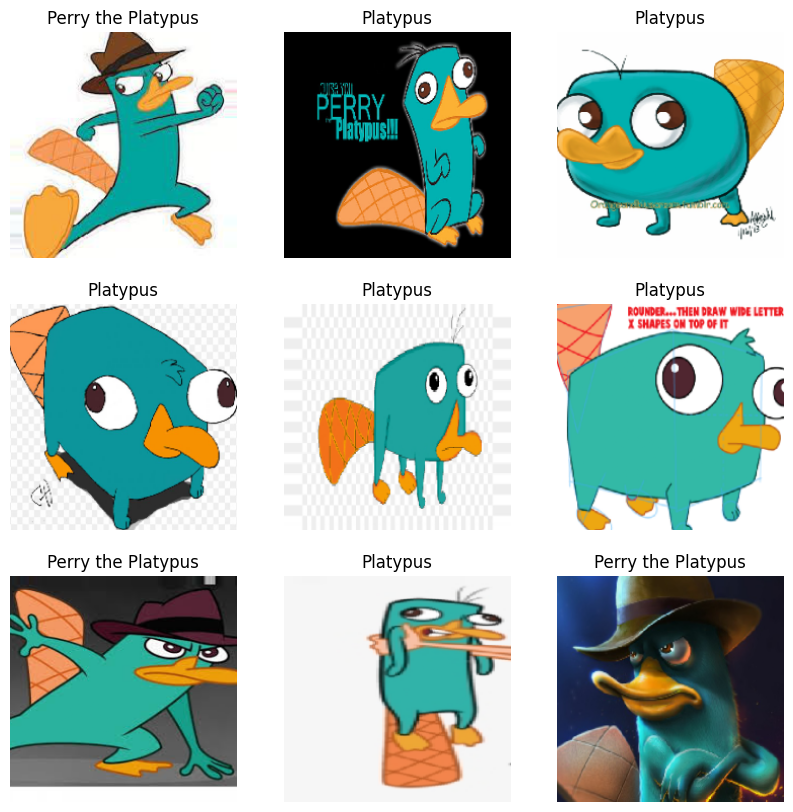

In [29]:
# Create a grid of subplots with the specified dimensions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

images, _ = train_generator.next()

# Plot each image with its corresponding label as the title
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    if _[i] == 0:
        ax.set_title("Perry the Platypus")
    else:
        ax.set_title("Platypus")
    ax.axis('off')
    
# Display the plot
plt.show()

Show the data augmentation in the validation set


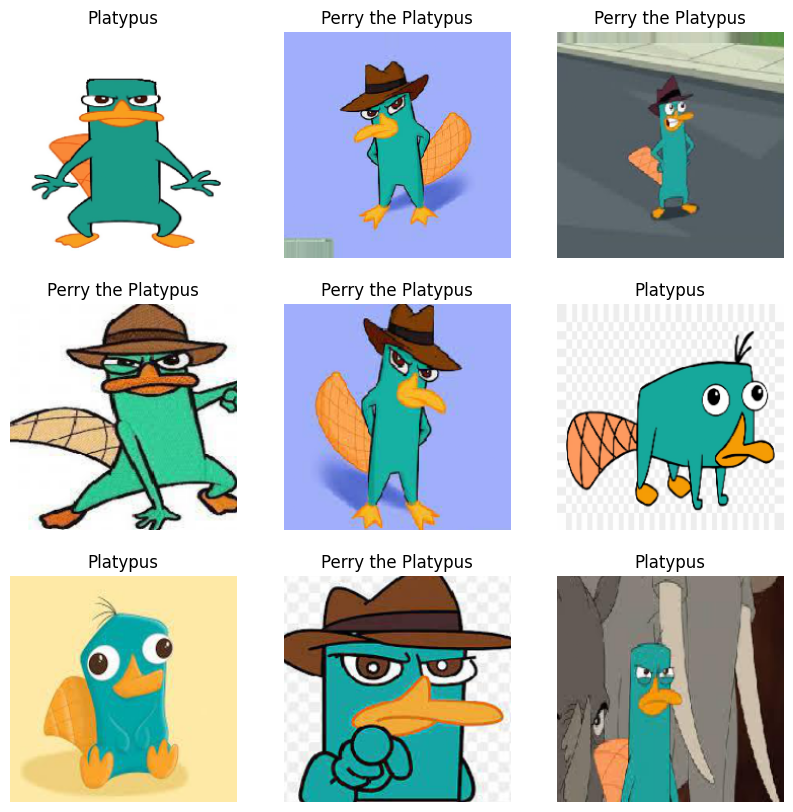

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

images, _ = val_generator.next()

# Plot each image with its corresponding label as the title
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    if _[i] == 0:
        ax.set_title("Perry the Platypus")
    else:
        ax.set_title("Platypus")
    ax.axis('off')
    
# Display the plot
plt.show()

## Heat map code

Credit: https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

In [31]:
# import the necessary packages
from tensorflow.keras.models import Model
import cv2
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()
  def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = tf.keras.models.Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
            self.model.output])
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap
  def overlay_heatmap(self, heatmap, image, alpha=0.5,
    colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
    return (heatmap, output)

In [32]:
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import argparse
import imutils

def visualise(model):

  IMG_SAVE_PATH_TESTING = 'test'
  outputs = []
  labels = []
  #classes = []
  for directory in os.listdir(IMG_SAVE_PATH_TESTING):
      path = os.path.join(IMG_SAVE_PATH_TESTING, directory)
      for image in os.listdir(path):
        url = os.path.join(path, image)
        orig = cv2.imread(url)
        resized = cv2.resize(orig, (224, 224))
        # load the input image from disk (in Keras/TensorFlow format) and
        # preprocess it
        image = load_img(url, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        preds = model.predict(image)
        # decode the ImageNet predictions to obtain the human-readable label
        label = round(preds[0][0] * 100,2)
        #print("[INFO] {}".format(label))
        # initialize our gradient class activation map and build the heatmap
        cam = GradCAM(model, 0)
        heatmap = cam.compute_heatmap(image)
        # resize the resulting heatmap to the original input image dimensions
        # and then overlay heatmap on top of the image
        heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
        outputs.append(output)
        labels.append(label)

  # Create a grid of subplots with the specified dimensions
  fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 10))

  # Plot each image with its corresponding label as the title
  for i, ax in enumerate(axes.flat):
      if i < 18:
        ax.imshow(outputs[i])
        ax.set_title(str(round(100 - labels[i],2)) + '% Perry')
        ax.axis('off')
  plt.axis('off')
  # Display the plot
  plt.show()

# Simple CNN Model 

## Make and Train Model

In [10]:
c_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Compile the model
c_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = c_model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
2/2 [==============================] - 13s 9s/step - loss: 0.7833 - accuracy: 0.5526 - val_loss: 0.6936 - val_accuracy: 0.4444
Epoch 2/10
2/2 [==============================] - 8s 6s/step - loss: 0.7398 - accuracy: 0.4474 - val_loss: 0.6983 - val_accuracy: 0.4444
Epoch 3/10
2/2 [==============================] - 10s 7s/step - loss: 0.6920 - accuracy: 0.5000 - val_loss: 0.6955 - val_accuracy: 0.4444
Epoch 4/10
2/2 [==============================] - 10s 8s/step - loss: 0.7051 - accuracy: 0.5263 - val_loss: 0.6950 - val_accuracy: 0.4444
Epoch 5/10
2/2 [==============================] - 8s 6s/step - loss: 0.6907 - accuracy: 0.4474 - val_loss: 0.6979 - val_accuracy: 0.4444
Epoch 6/10
2/2 [==============================] - 9s 2s/step - loss: 0.6830 - accuracy: 0.5789 - val_loss: 0.6995 - val_accuracy: 0.4444
Epoch 7/10
2/2 [==============================] - 10s 8s/step - loss: 0.6960 - accuracy: 0.5263 - val_loss: 0.7091 - val_accuracy: 0.4444
Epoch 8/10
2/2 [=====================

In [11]:
c_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

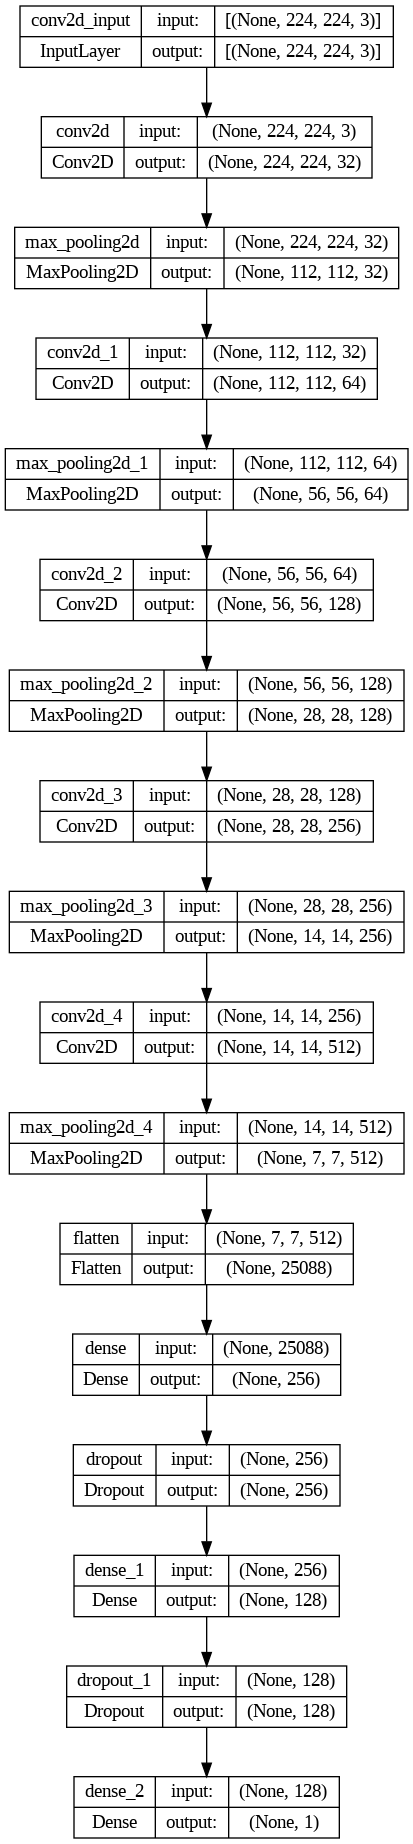

In [12]:
keras.utils.plot_model(c_model, show_shapes=True)

## Save Model

In [13]:
import os
from tensorflow.keras.models import load_model
c_model.save(os.path.join('models','simple_cnn_imageclassifier.h5'))

## Test Model

In [14]:
# Evaluate the model on the test set
test_loss, test_acc = c_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

1/1 [==============================] - 1s 1s/step - loss: 0.6924 - accuracy: 0.5294
Test accuracy: 0.529411792755127


## Visualise Heatmap on Test Set

1/1 [==============================] - 0s 96ms/step


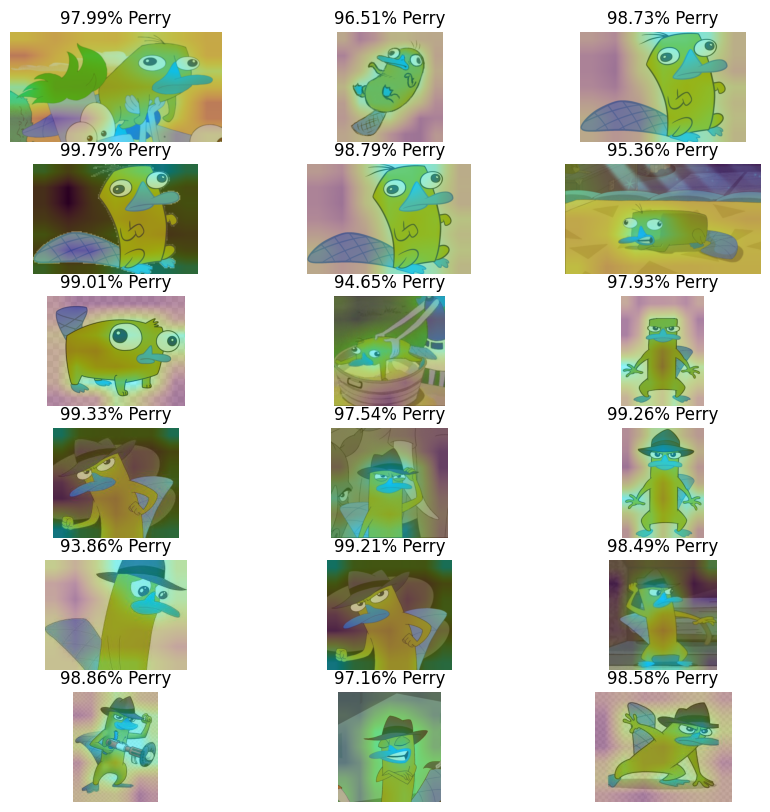

In [34]:
visualise(c_model)

# Transfer Learning Model 

## Make and Train Model

In [16]:
# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained layers

v_model = Sequential([
    vgg16,
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
v_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = v_model.fit(train_generator, epochs=10, validation_data=val_generator)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
2/2 [==============================] - 42s 35s/step - loss: 0.7411 - accuracy: 0.5526 - val_loss: 0.5692 - val_accuracy: 0.8889
Epoch 2/10
2/2 [==============================] - 31s 27s/step - loss: 0.5630 - accuracy: 0.7105 - val_loss: 0.5915 - val_accuracy: 0.6667
Epoch 3/10
2/2 [==============================] - 44s 14s/step - loss: 0.4417 - accuracy: 0.8421 - val_loss: 0.5143 - val_accuracy: 0.8889
Epoch 4/10
2/2 [==============================] - 43s 37s/step - loss: 0.2935 - accuracy: 0.9211 - val_loss: 0.5573 - val_accuracy: 0.6667
Epoch 5/10
2/2 [==============================] - 34s 12s/step - loss: 0.2236 - accuracy: 0.9474 - val_loss: 0.5063 - val_accuracy: 0.6667
Epoch 6/10
2/2 [==============================] - 39s 8s/step - loss: 0.1902 - accuracy: 0.9474 - val_loss: 0.4640 - val_accuracy: 0.6667
Epoch 7/10
2/2 [==============================] - 30s 26s/step - loss: 0.1124 - accuracy: 0.9474 - val

In [17]:
v_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 512)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)          147488    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

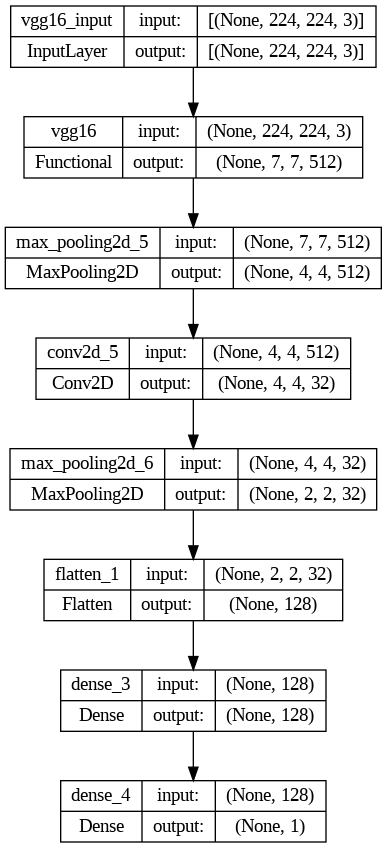

In [21]:
keras.utils.plot_model(v_model, show_shapes=True)

## Save Model

In [18]:
import os
from tensorflow.keras.models import load_model
v_model.save(os.path.join('models','vgg_imageclassifier.h5'))

## Test Model

In [19]:
# Evaluate the model on the test set
test_loss, test_acc = v_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

1/1 [==============================] - 9s 9s/step - loss: 0.7208 - accuracy: 0.7647
Test accuracy: 0.7647058963775635


## Visualise Heatmap on Test Set

1/1 [==============================] - 1s 1s/step


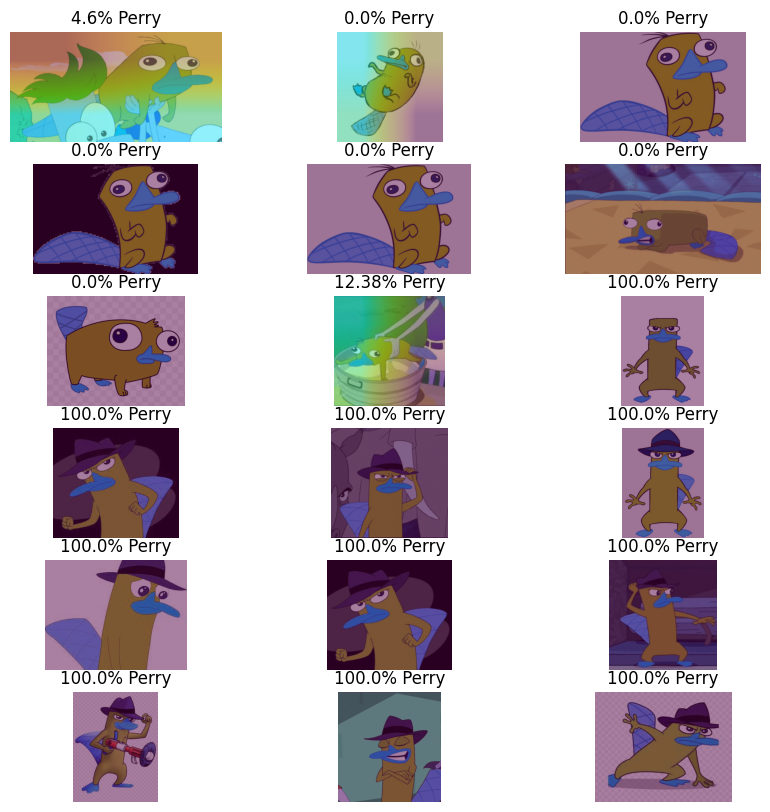

In [33]:
visualise(v_model)

# Classify New Images


Upload your own images here and run the code below to see how our transfer learning model performs on your image. 

In [106]:
from google.colab import files
uploaded = files.upload()

In [23]:
#Load models
new_model = load_model('models/vgg_imageclassifier.h5')
img = next(iter(uploaded))
image = load_img(img, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)
arr = new_model.predict(image)
print(str(round((1 - arr[0][0]) * 100,2)) + '% Perry the Playpus')
img_unchanged = cv2.imread(img,-1)
plt.imshow(cv2.cvtColor(img_unchanged, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

NameError: ignored